## 京都市中心エリアの消費傾向の地図を作成するプログラム

In [3]:
# 必要なモジュール
import pandas as pd
import numpy as np
import sys
import os
import geocoder as ge
import geopandas as gpd
import folium
import re
import itertools
import warnings
warnings.simplefilter("ignore")
from pyproj import CRS
from collections import defaultdict
import branca

In [4]:
# 自作モジュール
sys.path.append("../src")
from preprocess import preprocess, get_areadata_from_raw
from classify import classify
from filter import filter_by_date, filter_by_ind_blocks, filter_by_resi_blocks, filter_by_resi2_blocks
from filter import filter_by_ind, filter_by_gender, filter_by_age
from aggregate import process_data_by_ind_block, process_data_by_agesegment_gender, make_ind_age_gender
from aggregate import compute_gender_ratio_by_date_ind, compute_age_gender_ratio_by_date_ind, split_by_resi1
from aggregate import create_time_series_df
from aggregate import aggregate_by_code
from visualize_tool import get_sort_column, sort_by_ninzu_amount
from visualize import create_map_with_graduation, save_map
from heatmap import create_map_with_heatmap

In [7]:
#dummy_dataへのpath
jcb_path = "../data/dummy_data/dummy_data.csv"

In [8]:
#dummy_dataの読み込み
jcb_df = pd.read_csv(jcb_path,encoding="shift_jis")
#京都市中心エリアのGeoDataFrameを読み込む
gdf = gpd.read_file("../data/geojson/京都市中心GeoJSONデータ_v3.geojson")

In [11]:
#データの前処理
jcb_df = preprocess(jcb_df)
jcb_df = classify(jcb_df)
sale_df = jcb_df

In [12]:
#京都市中心エリアのデータの確認
sale_df.head(3)

date  post_code address1 address2 address3      ind  ninzu     amount  \
0 2023-01-01    6008001      京都府   京都市下京区       真町  053_紳士服      0  206259.64   
1 2023-01-01    6008001      京都府   京都市下京区       真町  053_紳士服      0  275971.35   
2 2023-01-01    6008001      京都府   京都市下京区       真町  121_軽飲食      0  227809.76   

   age  gender resi1   resi2 residence_block ind_block  
0   80       1   京都府  京都市右京区             京都府      衣料関連  
1   10       1   愛媛県    新居浜市       中国・四国ブロック      衣料関連  
2   10       2   東京都     中野区             東京都       飲食店

In [13]:
#京都市中心エリアのGeoDataFrameの確認
gdf.head(3)

full_address  post_code  clicked  \
0  京都府京都市東山区修道石垣町東側    6050913     True   
1  京都府京都市東山区修道石垣町西側    6050911     True   
2    京都府京都市東山区修道芳野町    6050878     True   

                                            geometry  
0  POLYGON ((135.77227 34.99422, 135.77223 34.994...  
1  POLYGON ((135.77176 34.99496, 135.77171 34.994...  
2  POLYGON ((135.7726 34.99481, 135.7727 34.99472...

#### 以下はプログラムの実行部分

In [14]:
#実行する部分
#➀特定の日,➁利用者の居住地,➂オリジナルの業種 をユーザーが入力し、JCBデータを抽出

#ユーザー入力でフィルタリング
# 抽出する期間を指定
start_date = input("期間の初めの日付を入力（例：20230101）：")
end_date = input("期間の終わりの日付を入力（例：20231231）：")
resi_blocks = input("消費者の居住地ブロックをカンマ区切りで入力（例: 東海ブロック,中国ブロック）未入力は全選択:")
resi2_blocks = input("消費者の住所の詳細を入力（例：京都市下京区,京都市上京区）未入力は全選択")
ind = input("オリジナルの業種をカンマ区切りで入力（例：021_ｽｰﾊﾟｰ,124_料理店,141_宿泊施設,181_タクシー）未入力は全選択：")
gender = input("性別を入力（１：男性,２：女性）未入力は全選択：")
age_range = input("年齢範囲を入力（例：20-29）未入力は全選択：")

#順にフィルタリングを適用
filtered_df = filter_by_date(sale_df,start_date=start_date, end_date=end_date)
filtered_df = filter_by_resi_blocks(filtered_df, resi_blocks)
filtered_df = filter_by_resi2_blocks(filtered_df,resi2_blocks)
filtered_df = filter_by_ind(filtered_df,ind)
filtered_df = filter_by_gender(filtered_df,gender)
filtered_df = filter_by_age(filtered_df,age_range)
filtered_df = filtered_df.rename({"code":"post_code"},axis=1)

excel_df = filtered_df.sort_values(by='amount',ascending=False).reset_index()
excel_df = excel_df.drop('index',axis=1)
#amountが多い順に、場所（郵便番号も一緒）、業種、ninzuを抽出した
#CSVファイルはfiltered_dfをCSV出力すれば良い

#郵便番号別で集計を行う
result_df = aggregate_by_code(filtered_df)
#ninzuかamountのユーザー入力による並び替え
#並び替えの基準をユーザー入力で取得
sort_column = get_sort_column()
sorted_df = sort_by_ninzu_amount(result_df,sort_column)

期間の初めの日付を入力（例：20190701）： 20230101
期間の終わりの日付を入力（例：20231218）： 20231231
消費者の居住地ブロックをカンマ区切りで入力（例: 東海ブロック,中国ブロック）未入力は全選択: 東京都
消費者の住所の詳細を入力（例：京都市下京区,京都市上京区）未入力は全選択 
オリジナルの業種をカンマ区切りで入力（例：021_ｽｰﾊﾟｰ,124_料理店,141_宿泊施設,181_タクシー）未入力は全選択： 
性別を入力（１：男性,２：女性）未入力は全選択： 
年齢範囲を入力（例：20-29）未入力は全選択： 
並び替えの基準を選択してください（a: amount / n: ninzu）： a


In [15]:
geo_df = gdf.merge(sorted_df,on='post_code',how='left')
value_column = sort_column

In [16]:
map1 = create_map_with_graduation(geo_df, value_column,"全体")
save_map(map1)

該当エリアを地図上に表示


#### 京都市中心エリア全てにおける可視化

In [17]:
map1

In [18]:
core_geo_df = geo_df.dropna(subset=['rank'])

In [19]:
map2 = create_map_with_graduation(core_geo_df, value_column,"全体")
save_map(map2)

該当エリアを地図上に表示


#### 京都市中心エリアにおいて指定した条件のデータがある町を可視化

In [20]:
map2

#### 消費額の対数変換をヒートマップで可視化

In [21]:
# 2025/06/13 追加
map3 = create_map_with_heatmap(core_geo_df, value_column)
save_map(map3)

該当エリアを地図上に表示


In [22]:
map3

In [19]:
core_geo_df.head(5)

full_address  post_code  clicked  \
1     京都府京都市東山区修道石垣町西側    6050911     True   
2       京都府京都市東山区修道芳野町    6050878     True   
9        京都府京都市東山区修道袋町    6050911     True   
12  京都府京都市東山区修道五条橋東二丁目    6050846     True   
14   京都府京都市東山区修道妙法院前側町    6050932     True   

                                             geometry  ninzu       amount  \
1   POLYGON ((135.77176 34.99496, 135.77171 34.994...    7.0   1379091.40   
2   POLYGON ((135.7726 34.99481, 135.7727 34.99472...    1.0    101028.57   
9   POLYGON ((135.7713 34.99439, 135.77129 34.9943...    7.0   1379091.40   
12  POLYGON ((135.77079 34.99587, 135.77081 34.995...   94.0   8327588.21   
14  POLYGON ((135.77482 34.99242, 135.7748 34.9922...   38.0  10309485.54   

     rank  
1   380.0  
2   633.0  
9   380.0  
12  131.0  
14  109.0

count    9.800000e+02
mean     2.612578e+07
std      1.500294e+08
min      1.374470e+03
25%      9.720600e+05
50%      3.962096e+06
75%      1.626798e+07
max      2.820367e+09
Name: amount, dtype: float64
歪度 (skewness): 13.92459826659434


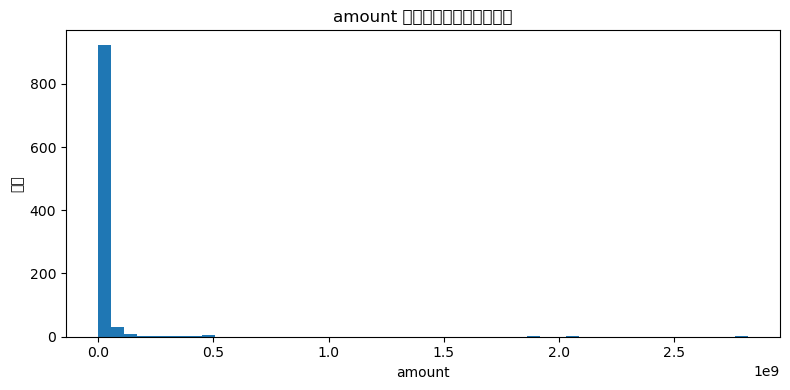

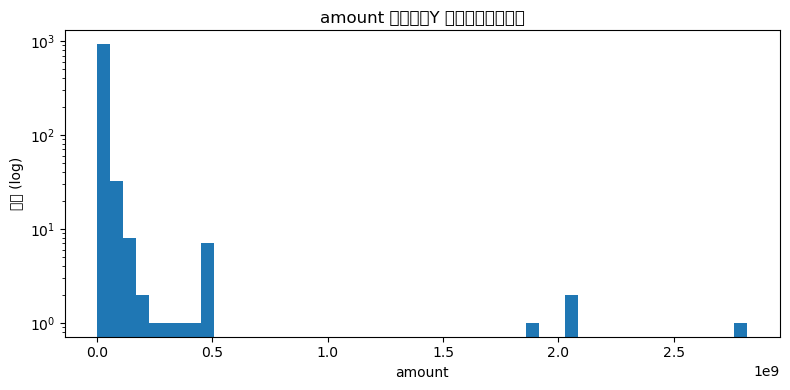

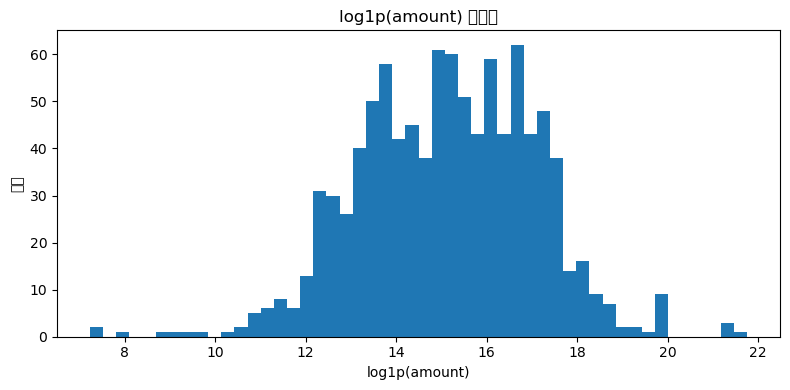

In [23]:
import numpy as np
import matplotlib.pyplot as plt

df = core_geo_df

# 要約統計量
print(df['amount'].describe())
print("歪度 (skewness):", df['amount'].skew())

# ヒストグラム（通常スケール）
plt.figure(figsize=(8,4))
plt.hist(df['amount'], bins=50)
plt.title('amount の分布（通常スケール）')
plt.xlabel('amount')
plt.ylabel('件数')
plt.tight_layout()
plt.show()

# ヒストグラム（対数スケール）
plt.figure(figsize=(8,4))
plt.hist(df['amount'], bins=50, log=False)           # ヒストグラム自体は通常だが
plt.yscale('log')                                    # Y 軸を対数にして表示
plt.title('amount の分布（Y 軸対数スケール）')
plt.xlabel('amount')
plt.ylabel('件数 (log)')
plt.tight_layout()
plt.show()

# 対数変換後の分布（参考）
log_amt = np.log1p(df['amount'])
plt.figure(figsize=(8,4))
plt.hist(log_amt, bins=50)
plt.title('log1p(amount) の分布')
plt.xlabel('log1p(amount)')
plt.ylabel('件数')
plt.tight_layout()
plt.show()
